In [123]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap

modpath = os.path.abspath(os.path.join('/home/chrenkl/Projects/MDT_tilt/Python'))
if modpath not in sys.path:
    sys.path.append(modpath)

import nemo_tools as nt
from create_bathymetry import read_etopo

In [124]:
# project directory
projdir = '/home/chrenkl/Projects/nemo_bathymetry'

lonmin = -60.5
lonmax = -55.5
lat = 46.75

# read ETOPO data
ETOPO = read_etopo(os.path.join(projdir, 'data/external/ETOPO1',
                                'ETOPO1_Bed_g_gmt4.grd'),
                   lonmin=lonmin, lonmax=lonmax, latmin=lat, latmax=lat)

# set land values to zero
ETOPO.z[ETOPO.z >=0] = 0.

# read ETOPO data (cell-registered)
ETOPOc = read_etopo(os.path.join(projdir, 'data/external/ETOPO1',
                                'ETOPO1_Bed_c_gmt4.grd'),
                   lonmin=lonmin, lonmax=lonmax, latmin=lat, latmax=lat)

# set land values to zero
ETOPOc.z[ETOPOc.z >=0] = 0.

Read ETOPO data.
Read ETOPO data.


In [120]:
# file name of cleaned and corrected insitu data
insitufile = os.path.join(projdir, 'data/interim/in-situ_corrected.h5')

InSitu = pd.read_hdf(insitufile, 'InSitu')

InSitu = InSitu[(InSitu.lon >= lonmin) & (InSitu.lon <= lonmax) & (InSitu.lat >= lat-0.01) & (InSitu.lat <= lat+0.01)]

InSitu.head()

,lon,lat,depth
11206578,-60.279729,46.748964,-74.9
11206579,-60.271729,46.751464,-85.8
11206582,-60.237800,46.744734,-168.2
11206583,-60.209431,46.743165,-150.0
11206586,-60.202832,46.753064,-148.4


In [121]:
# interpolate in-situ to ETOPO
# create map projection for interpolations
proj = Basemap(projection='merc',
               llcrnrlat=lat-.1, urcrnrlat=lat+.1,
               llcrnrlon=lonmin, urcrnrlon=lonmax,
               resolution='h')

ndata = len(ETOPO.z)

xx, yy = np.meshgrid(ETOPO.x.values, ETOPO.y.values)
xin, yin = proj(xx.ravel(), yy.ravel())

xout, yout = proj(InSitu.lon.values, InSitu.lat.values)

gridind = griddata(np.column_stack((xin, yin)), np.arange(ndata), (xout, yout), method='nearest')

gridinsitu = np.zeros(ndata)

for ind in np.arange(ndata):
    tmp = InSitu.depth[gridind == ind]
    if len(tmp) > 0:
        gridinsitu[ind] = np.median(tmp)

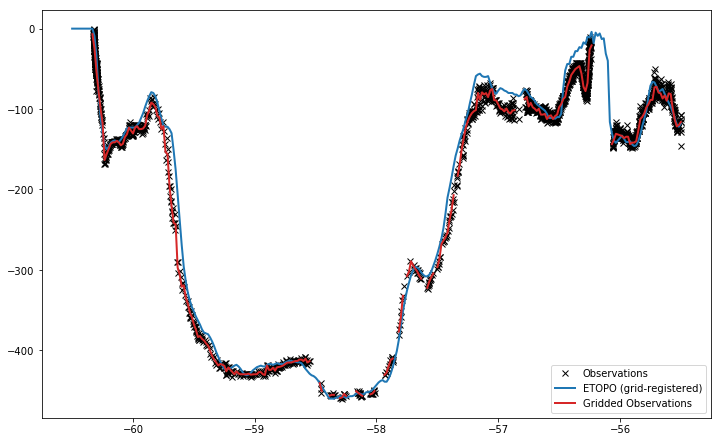

In [122]:
# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig = plt.figure(figsize=(12., 7.5))
ax = fig.add_subplot(111)

# plot in-situ data
ax.plot(InSitu.lon, InSitu.depth, 'x', color='k', label='Observations')

# plot ETOPO
ax.plot(ETOPO.x, ETOPO.z, '-', color='C0', linewidth=2, label='ETOPO (grid-registered)')

# plot ETOPO
# ax.plot(ETOPOc.x, ETOPOc.z, '-', color='C1', linewidth=2, label='ETOPO (cell-registered)')

# plot ETOPO
ax.plot(ETOPO.x, np.ma.masked_values(gridinsitu, 0.), '-', color='C3', linewidth=2, label='Gridded Observations')

# legend
ax.legend(loc=4)

fig.tight_layout

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/ETOPO_vs_in-situ.pdf')

# save figure
fig.savefig(figname)